# Overview
For this capstone project I will be working on identifying online harassment using NLP.  Why focus on harassment?  Well, for starters, it's a problem that affects a quarter of the population in the U.S.  Additionally, according to a [2021 Pew research poll]( (https://www.pewresearch.org/internet/2021/01/13/the-state-of-online-harassment/)), 79% of respondants "say social media companies are doing an only fair or poor job at addressing online harassment or bullying on their platforms."  Our goal is to construct a virtual moderator, or vMOD, a NLP model that is capable of predicting if a comment is harassment or not, and automatically blocks users who are sending hateful comments.


"Fully 33% of women under 35 say they have been sexually harassed online", For those who identify as LBGTQA, "51% have been targeted for more severe forms of online abuse."

"Among adults who have been harassed online, roughly half of women (47%) say they think they have encountered harassment online because of their gender, whereas 18% of men who have been harassed online say the same. Similarly, about half or more Black (54%) or Hispanic online harassment targets (47%) say they were harassed due to their race or ethnicity, compared with 17% of White targets."


[Plos article](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0221152)


# Data Understanding


Our data comes from a [Kaggle competetion](https://www.kaggle.com/competitions/jigsaw-toxic-comment-classification-challenge/data), Identifying Toxic Comments, a dataset comprising of 159571 data points.
measures of central tendency, spread, give broad narrative of data itself.  

How we clean and preprocess our data will have a major effect on the conclusions we can draw

The Natural Language Tool Kit (NLTK) is one of the most popular Python libraries for NLP

Regular Expressions are an important part of NLP, which can be used for pattern matching and filtering

**Feature Engineering** is essential when working with text data, and to understand the dynamics of your text:
* Common feature engineering techniques are removing stop words, stemming, lemmatization, and n-grams
* When diving deeper into grammar and linguistics, context-free grammars and part-of-speech tagging is important
* In this context, parse trees can help computers when dealing with ambiguous words


Then talk about automating process using [Kaggle API key](https://www.kaggle.com/docs/api).

Per [A Literature Survey on Algorithms for Multi-label
Learning](https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.364.5612&rep=rep1&type=pdf) "in multi-label classification, predictions for an instance is a set of labels and, therefore, the prediction
can be fully correct, partially correct (with different levels of correctness) or fully incorrect. None of
these existing evaluation metrics capture such notion in their original form. This makes evaluation
of a multi-label classifier more challenging than evaluation of a single label classifier."

## Import Data
In this section we'll take a preliminary look at our data to get a feel for what we're working with. Let's begin with our import statements and then by taking a look at the contents of our train data directory.

In [2]:
import re, os, csv
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from google.colab import drive


import tensorflow as tf
import tensorflow_hub as hub

from tensorflow import keras
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.models import Model, Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Flatten, Input, LSTM, Embedding, Dropout, GlobalMaxPool1D, SpatialDropout1D, BatchNormalization
from keras.preprocessing import sequence


import shutil

import nltk
from nltk import pos_tag
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline as Pipe



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
 # Get current directory
print(os.getcwd())

# Get contents of the directory
print(os.listdir())

/content
['.config', 'drive', 'sample_data']


In [4]:
# Set path to xrays.  Hint- right click on the file you want to copy file path
drive_path = '/content/drive/MyDrive/Colab_Notebooks/jigsaw-toxic-comment-classification-challenge.zip'


In [5]:
# Navigate to file
!cp '{drive_path}' .

In [ ]:
# Get current directory/confirm correct path
print(os.getcwd())

# Get contents of the directory
print(os.listdir())

/content
['.config', 'drive', 'jigsaw-toxic-comment-classification-challenge.zip', 'sample_data']


In [6]:
# Unzip
!unzip '/content/jigsaw-toxic-comment-classification-challenge.zip'

Archive:  /content/jigsaw-toxic-comment-classification-challenge.zip
  inflating: sample_submission.csv.zip  
  inflating: test.csv.zip            
  inflating: test_labels.csv.zip     
  inflating: train.csv.zip           


In [7]:
# import csv data as pd df
train = pd.read_csv('train.csv.zip')
test = pd.read_csv('test.csv.zip')
test_labels= pd.read_csv('test_labels.csv.zip')


## Inspect Data

In [ ]:
train.shape

(159571, 8)

In [ ]:
print("Number of Train NaN:", train['comment_text'].isnull().sum())
print("Number of Test NaN:", test['comment_text'].isnull().sum())
print("Number of Label NaN:", test_labels.isnull().sum())


Number of Train NaN: 0
Number of Test NaN: 0
Number of Label NaN: id               0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64


In [ ]:
train.head(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0


In [ ]:
len = train.comment_text.len()
print("Shortest comment:", len.min(), "words")
print("Longest comment:", len.max(), "words")
print("Average comment:", len.mean().round(0), "words")




Shortest comment: 6 words
Longest comment: 5000 words
Average comment: 394.0 words


## Clean Target (OHE)

In [7]:
ytrain = train[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']]

from sklearn.preprocessing import MultiLabelBinarizer

MultiLabelBinarizer().fit_transform(ytrain)

array([[0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0],
       [1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0],
       [0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0],
       [1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1]])

## Train, Test, Val Split

In order to ensure our data has no leakage, we'll perform an intitial train test split before cleaning our corpus

In [8]:
# Train dataframes
Xtrain = train['comment_text'].str.lower()
ytrain = train[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']]


In [9]:
#Train test split
X_train_1, X_test, y_train_1, y_test = train_test_split(Xtrain, ytrain,
                                                    test_size=0.15, random_state=42)


In [10]:
 # Val split *Validation data abels for the test data could not be used per Kaggle "value of -1 indicates it was not used for scoring; (Note: file added after competition close!)"
 X_train, X_val, y_train, y_val= train_test_split(X_train_1, y_train_1,
                                                    test_size=0.05, random_state=42)

In [ ]:
# Examine train test val
print("Train Comments:", X_train.head(2))
print("--------------------------------")

print("Test Comments:", X_test.head(2))
print("--------------------------------")

print("Val Comments:", X_val.head(2))
print("--------------------------------")

print("Train Target Variables:", y_train.head(2))
print("--------------------------------")

print("Test Target Variables:", y_test.head(2))
print("--------------------------------")

print("Val Target Variables:", y_val.head(2))
print("--------------------------------")


Train Comments: 159023    service award\nhello. i noticed you list yours...
76867     "\nwelcome!hello and welcome to wikipedia. tha...
Name: comment_text, dtype: object
--------------------------------
Test Comments: 119105    geez, are you forgetful!  we've already discus...
131631    carioca rfa \n\nthanks for your support on my ...
Name: comment_text, dtype: object
--------------------------------
Val Comments: 7608     "\n ok, i understand. -) i've been a racist fo...
20119    again again again \n\nthis is not going to sto...
Name: comment_text, dtype: object
--------------------------------
Train Target Variables:         toxic  severe_toxic  obscene  threat  insult  identity_hate
159023      0             0        0       0       0              0
76867       0             0        0       0       0              0
--------------------------------
Test Target Variables:         toxic  severe_toxic  obscene  threat  insult  identity_hate
119105      0             0        0       0

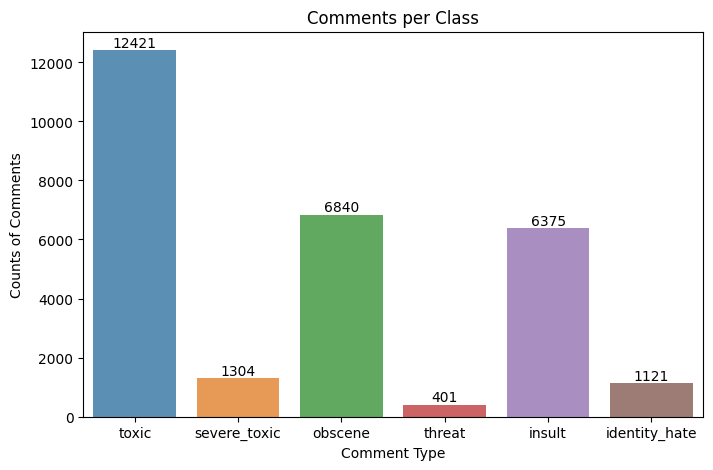

In [ ]:
cols = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

val_counts = y_train[cols].sum()

plt.figure(figsize=(8,5))
ax = sns.barplot(x= val_counts.index, y= val_counts.values, alpha=0.8)

plt.title("Comments per Class")
plt.xlabel("Comment Type")
plt.ylabel("Counts of Comments")

rects = ax.patches
labels = val_counts.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height+5, label, ha="center", va="bottom")


plt.show()

In [ ]:
# Find total number of toxic comments in train
x=train.iloc[:,2:].sum()
print("Total number of toxic comments:", x.sum())


Total number of toxic comments: 35098


### Class Imbalance
We can see there is a clear class imbalance in our data-only 35,098 comments are considered toxic, out of our dataset of 159,571; far more records have no toxic languge than do.  We'll need to take this into account when building our model.


# Data Preprocessing

We've already lowercased the letters of our corpus, and now we'll untertake our next step, tokenizing our corpus, or splitting each comment into a series of words.  We'll have to make some decisions now about whether we remove stop words, what kinds of regex expressions we should use to clean the comments, if we should stem, lemmatize, or leave our text data as is before we come to our next step, vectorization.

Because our dataset is quite large, we'll begin by removing stop words.  We'll do this because large datasets become highly dimensionsal after they've been vectorized, and to minimize processing times we'll need to reduce the amount of tokens we pass in to our vector.  Removing stop words- the most common words in english that have little value in this use case, will help us do so.

We'll also use a regex expression to clean up some of the comments.  As we could see in our datatframe, there's many examples of strange punctuation that could adversly affect our model's performance, and we'll want to edit those out as well.

We'll hold off on stemming or lemmatizing for now.  If our results from our initial models are unsatisfactory, we'll circle back to stemming our tokens.



### Clean Corpus

In [11]:
STOPWORDS = set(stopwords.words('english')) - {'not', 'no' }
def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = re.sub(r"\n", "", text)
    text = text.strip(' ')
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwors from text


    return text

In [12]:
X_train = X_train.map(lambda com : clean_text(com))
X_test = X_test.map(lambda com : clean_text(com))
X_val = X_val.map(lambda com : clean_text(com))



# Vectorization
In order to model and make predictions with our data we'll need to tranform our word tokens into vectors, or an array of 0's and 1's.

Vectorization allows our model to:
* Find word predictions
* Find word similarities
* Represent words in a lower-dimensional space
* Allow words with similar meanings to have a similar representation
* Approximate meaning

The most straightforward vectorizer in sklearn.feature_extraction.text is the CountVectorizer, which will simply count the number of each word type in each document.  Two other strategies include:

* Bag of Words: A a simple, yet effective text encoding technique. Corpus is tokenized, only unique words are selected to create the vocabulary and then sorted by alphabetical order.  Single words or n-grams can be used for analysis.

* TF-IDF: Term Frequency–Inverse Document Frequency, is a numerical statistic that’s intended to reflect how important a word is to a document.  This is a slightly more sophisticated version of bag of words.

We'll use a pipeline to send both the CountVectorizer and TfidfTransformer vectors through a Multinomial Naive Bayes classifier, wrapping that in a MultiOutputClassifier to account for our 6 target variables.



# Bayes's Theorem
"...with NB models generally
outperforming the sophisticated, structure-sensitive
models explored in recent work. Furthermore, by
combining generative and discriminative classifiers,
we present a simple model variant where an SVM is
built over NB log-count ratios as feature values, and
show that it is a strong and robust performer over all
the presented tasks"

 Multinomial Naive Bayes (MNB) better att snippets.  Support Vector Machine (SVM) better at full length and  SVM with NB(Naive Bayes) features (NBSVM) doing well on both
[Baselines and Bigrams: Simple, Good Sentiment and Topic Classification](https://nlp.stanford.edu/pubs/sidaw12_simple_sentiment.pdf)



Build pipeline

In [14]:
nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultiOutputClassifier(MultinomialNB())),
               ])
nb.fit(X_train, y_train)

y_pred = nb.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=y_test.columns))



accuracy 0.9014872994652406
               precision    recall  f1-score   support

        toxic       0.99      0.18      0.30      2260
 severe_toxic       0.00      0.00      0.00       225
      obscene       0.99      0.11      0.20      1279
       threat       1.00      0.02      0.04        53
       insult       0.98      0.05      0.10      1192
identity_hate       0.00      0.00      0.00       227

    micro avg       0.99      0.11      0.21      5236
    macro avg       0.66      0.06      0.11      5236
 weighted avg       0.90      0.11      0.20      5236
  samples avg       0.02      0.01      0.01      5236



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision is the correct predictions divided by total predictions made by model.  Our model does an excellent job of identifying regular speech, but lags in the other target possibilities.  Recall is a measure of true positives the tp/tp + fn, and as we can see this is where we encounter our problem.  Our model clearly has a difficult time determining toxic speech.

Precision Measures the accuracy of positive predictions. It quantifies the number of positive class predictions that actually belong to the positive class. We had a very small percentage of false positives, only 1%


Recall Measures the completeness of positive predictions. It quantifies the number of positive class predictions made out of all positive examples in the dataset.  The recall of our model was very poor, only 12%  of our total positives were captured.

F1 scores are the harmonic mean of precision and recall, and often is more accurate than looking solely at precision.  From our F1 scores of 30%, we can see that we're doing a poor job using a multioutput model.  Let's see if switching it to a binary output helps to improve our ability to identify toxic speech.


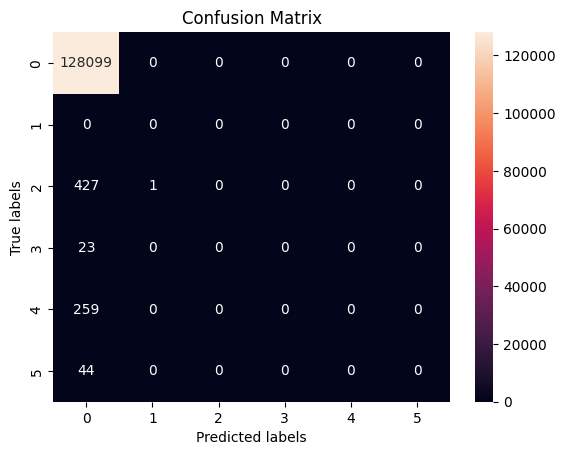

In [15]:
lables = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
y_pred = np.argmax(nb.predict(X_train), axis=1)
thresh = 0.5
y_pred = (y_pred > thresh)

ax= plt.subplot()

cm = confusion_matrix(np.asarray(y_train).argmax(axis=1), y_pred)
sns.heatmap(cm, annot=True, fmt='g', ax=ax, label=lables);

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');



## Binary target
We'll try exactly the same preprocessing with exactly the same model, AND resampling using RandomOverSampler to account for our class imbalance with our target data reshaped as binary below.

In [13]:
# Binarize target variables by converting all 6 types of toxic speech to 1 if cols= 'toxic', 'severe_toxic', 'obscene', 'threat','insult', 'identity_hate'

cols=['toxic', 'severe_toxic', 'obscene', 'threat','insult', 'identity_hate']
train['Toxic']=train[cols].max(axis=1).apply(lambda x: 1 if x ==1 else 0)

In [ ]:
train.head(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,Toxic
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0,1
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0,0
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0,0


In [14]:
# Train test dataframes
Xtrain = train['comment_text'].str.lower()
ytrain = train['Toxic']


In [15]:
#Train test split
X_train_1, X_test_bi, y_train_1, y_test_bi = train_test_split(Xtrain, ytrain,
                                                    test_size=0.15, random_state=42)


In [16]:
 # Val split *Validation data abels for the test data could not be used per Kaggle "value of -1 indicates it was not used for scoring; (Note: file added after competition close!)"
 X_train_bi, X_val_bi, y_train_bi, y_val_bi= train_test_split(X_train_1, y_train_1,
                                                    test_size=0.05, random_state=42)

In [15]:
X_train_bi = X_train_bi.map(lambda com : clean_text(com))
X_test_bi = X_test_bi.map(lambda com : clean_text(com))
X_val_bi = X_val_bi.map(lambda com : clean_text(com))

In [ ]:
nb2 = Pipe([('vect', CountVectorizer()),
            ('tfidf', TfidfTransformer()),
            ('sampler', RandomOverSampler()),
            ('clf', MultinomialNB()),
])
nb2.fit(X_train_bi, y_train_bi)

y_pred_bi = nb2.predict(X_test_bi)

print('accuracy %s' % accuracy_score(y_pred_bi, y_test_bi))
print(classification_report(y_test_bi, y_pred_bi))

accuracy 0.896014371657754
              precision    recall  f1-score   support

           0       0.98      0.90      0.94     21542
           1       0.49      0.87      0.63      2394

    accuracy                           0.90     23936
   macro avg       0.74      0.89      0.78     23936
weighted avg       0.93      0.90      0.91     23936



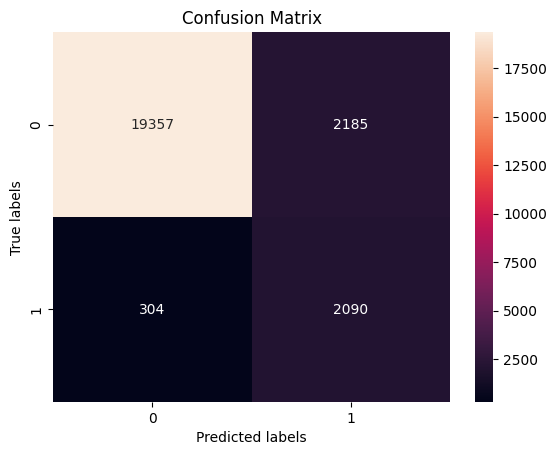

In [ ]:
ax= plt.subplot()

cm = confusion_matrix(np.asarray(y_test_bi), y_pred_bi)
sns.heatmap(cm, annot=True, fmt='g', ax=ax, label=lables);

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');

This model does a pretty great job of identifying toxic speech, although we've got a few more cases of normal speech falsely being categorized as toxic here.  Let's see if using a neural network can reduce our false positives and improve our ability to identify toxic speech



#  Model Using Embeddings
 need to dissect and rewrite in my own code

```
# This is formatted as code
```



In [ ]:
# Set parameters:
max_features = 50000
maxlen = 5000
batch_size = 32
embedding_dims = 64
epochs = 4

In [ ]:
comment_input = Input((maxlen,))

# we start off with an efficient embedding layer which maps
# our vocab indices into embedding_dims dimensions
comment_emb = Embedding(max_features, embedding_dims, input_length=maxlen)(comment_input)

# we add a GlobalMaxPool1D, which will extract information from the embeddings
# of all words in the document
# WHAT/HOW DOES SPATIAL DROPOUT WORK
comment_emb = SpatialDropout1D(0.25)(comment_emb)
max_emb = GlobalMaxPool1D()(comment_emb)

# normalized dense layer followed by dropout
main = BatchNormalization()(max_emb)
main = Dense(64)(main)
main = Dropout(0.5)(main)

# We project onto a six-unit output layer, and squash it with sigmoids:
output = Dense(6, activation='sigmoid')(main)

model = Model(inputs=comment_input, outputs=output)
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


Build model...


In [ ]:
hist = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/4
3624/3624 [==============================] - 62s 17ms/step - loss: 0.1014 - accuracy: 0.7893 - val_loss: 0.0566 - val_accuracy: 0.9943
Epoch 2/4
3624/3624 [==============================] - 61s 17ms/step - loss: 0.0616 - accuracy: 0.8429 - val_loss: 0.0542 - val_accuracy: 0.9924
Epoch 3/4
3624/3624 [==============================] - 60s 17ms/step - loss: 0.0551 - accuracy: 0.7719 - val_loss: 0.0525 - val_accuracy: 0.9923
Epoch 4/4
3624/3624 [==============================] - 61s 17ms/step - loss: 0.0514 - accuracy: 0.7318 - val_loss: 0.0515 - val_accuracy: 0.9936


In [ ]:
model_history = model.fit(X_train,
                          X_test,
                          batch_size=100,
                          epochs=5,
                          validation_data=(y_train, y_test))


In [ ]:
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Making things BERT friendly

BERT, which stands for Bidirectional Encoder Representations from Transformers, is a cutting edge pretrained black box NLP model developed by Google.  

"Transformers are a multi-head attention mechanisms that learns contextual relations between the words in the given text.
Generally, a transformer consists of two separate parts - an encoder that accepts the text input and an optional
decoder or a sigmoid/softmax layer that produces a prediction for the task. BERT is a pre-training approach that uses
this architecture for modeling." [Toxic Comment Classification using Transformers](https://www.ieomsociety.org/singapore2021/papers/366.pdf)

"Transformers are a multi-head attention mechanisms that learns contextual relations between the words in the given text.
Generally, a transformer consists of two separate parts - an encoder that accepts the text input and an optional
decoder or a sigmoid/softmax layer that produces a prediction for the task. BERT is a pre-training approach that uses
this architecture for modeling." [Toxic Comment Classification using Transformers](https://www.ieomsociety.org/singapore2021/papers/366.pdf)


The tokenizer returns a dictionary with three important items:

* input_ids are the indices corresponding to each token in the sentence.
* attention_mask indicates whether a token should be attended to or not.
* token_type_ids identifies which sequence a token belongs to when there is more than one sequence.



Special thanks to HARSH JAIN for their Kaggle article [BERT for "Everyone"](https://www.kaggle.com/code/harshjain123/bert-for-everyone-tutorial-implementation), from which much of the following code is excerpted.


First let's make the data compliant with BERT-
There is a very helpful function, encode_plus provided in the Tokenizer class which performs the following operations:

Tokenize the text
* Add special tokens - [CLS] and [SEP]
* create token IDs
* Pad the sentences to a common length
* Create attention masks for the above PAD tokens



We'll begin with our import statements:



In [20]:
import torch
from tqdm.notebook import tqdm

import transformers

from transformers import BertTokenizer, BertForSequenceClassification, TFBertModel, AutoModel, BertTokenizerFast
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

import tensorflow as tf
import torch.nn as nn

from transformers import AdamW

#to avoid warnings
import warnings
warnings.filterwarnings('ignore')


## Check GPU
In order to run BERT will need the increased processing power of a GPU.  We can discover which (if any) processor we're using by running the following code:

In [1]:

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
      raise SystemError('GPU device not found')


Found GPU at: /device:GPU:0


In [17]:
# Install Transformers
pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 60.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 39.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 97.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 83.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 38.3 MB/s eta 0:00:00


In [18]:
# Clean text
X_train_BERT = X_train.map(lambda com : clean_text(com))
X_test_BERT = X_test.map(lambda com : clean_text(com))
X_val_BERT = X_val.map(lambda com : clean_text(com))


## Tokenize Text and Convert to Tensors

In [21]:
# Tokenize texts
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    X_train_BERT.tolist(),
    max_length = 128,
    pad_to_max_length=True,
    truncation=True
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    X_val_BERT.tolist(),
    max_length = 128,
    pad_to_max_length=True,
    truncation=True
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    X_test_BERT.tolist(),
    max_length = 128,
    pad_to_max_length=True,
    truncation=True
)

In [22]:
## convert lists to tensors

train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(y_train_bi.tolist())

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(y_val_bi.tolist())

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(y_test_bi.tolist())

## Data Loader


In [46]:

#define a batch size
batch_size = 129

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)


## Build BERT Classifier

In [47]:
# import BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-uncased')

# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False

In [49]:
class BERT_Arch(nn.Module):

    def __init__(self, bert):
        super(BERT_Arch, self).__init__()

        self.bert = bert

        # dropout layer
        self.dropout = nn.Dropout(0.1)

        # relu activation function
        self.relu =  nn.ReLU()

        # dense layer 1
        self.fc1 = nn.Linear(768,512)

        # dense layer 2 (Output layer)
        self.fc2 = nn.Linear(512,2)
     #softmax activation function
        self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):

        #pass the inputs to the model
        _, cls_hs = self.bert(sent_id, attention_mask=mask, return_dict=False)

        x = self.fc1(cls_hs)

        x = self.relu(x)

        x = self.dropout(x)

        # output layer
        x = self.fc2(x)

        # apply softmax activation
        x = self.softmax(x)

        return x

In [50]:
# Define GPU device
device = torch.device("cuda")

In [51]:

# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert)

# push the model to GPU
model = model.to(device)

## Optimizers

In [52]:

# define the optimizer
optimizer = AdamW(model.parameters(),lr = 1e-5)

In [53]:
from sklearn.utils.class_weight import compute_class_weight

#compute the class weights
class_weights = compute_class_weight('balanced', classes= np.unique(y_train_bi), y= y_train_bi)
class_weights


array([0.55694687, 4.89005693])

In [54]:
# converting list of class weights to a tensor
weights= torch.tensor(class_weights, dtype=torch.float)

# push to GPU
weights = weights.to(device)


# define the loss function
cross_entropy  = nn.NLLLoss(weight=weights)

# number of training epochs
epochs = 3

## Function to Train Model

In [55]:
# function to train the model
def train():

    model.train()
    total_loss, total_accuracy = 0, 0

    # empty list to save model predictions
    total_preds=[]

    # iterate over batches
    for step,batch in enumerate(train_dataloader):

        # progress update after every 50 batches.
        if step % 50 == 0 and not step == 0:
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

        # push the batch to gpu
        batch = [r.to(device) for r in batch]

        sent_id, mask, labels = batch

        # clear previously calculated gradients
        model.zero_grad()

         # get model predictions for the current batch
        preds = model(sent_id, mask)

        # compute the loss between actual and predicted values
        loss = cross_entropy(preds, labels)

        # add on to the total loss
        total_loss = total_loss + loss.item()

        # backward pass to calculate the gradients
        loss.backward()

        # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # update parameters
        optimizer.step()

        # model predictions are stored on GPU. So, push it to CPU
        preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

     # compute the training loss of the epoch
    avg_loss = total_loss / len(train_dataloader)

      # predictions are in the form of (no. of batches, size of batch, no. of classes).
      # reshape the predictions in form of (number of samples, no. of classes)
    total_preds  = np.concatenate(total_preds, axis=0)

    #returns the loss and predictions
    return avg_loss, total_preds



## Function to Evaluate Model

In [56]:
# function for evaluating the model
def evaluate():

    print("\nEvaluating...")

    # deactivate dropout layers
    model.eval()

    total_loss, total_accuracy = 0, 0

    # empty list to save the model predictions
    total_preds = []

    # iterate over batches
    for step,batch in enumerate(val_dataloader):

        # Progress update every 50 batches.
        if step % 50 == 0 and not step == 0:

        # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

        # push the batch to gpu
        batch = [t.to(device) for t in batch]

        sent_id, mask, labels = batch

        # deactivate autograd
        with torch.no_grad():

            # model predictions
            preds = model(sent_id, mask)

            # compute the validation loss between actual and predicted values
            loss = cross_entropy(preds,labels)

            total_loss = total_loss + loss.item()

            preds = preds.detach().cpu().numpy()

            total_preds.append(preds)

            # compute the validation loss of the epoch
    avg_loss = total_loss / len(val_dataloader)

    # reshape the predictions in form of (number of samples, no. of classes)
    total_preds  = np.concatenate(total_preds, axis=0)

    return avg_loss, total_preds

## Run Model

In [57]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):

    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))

    #train model
    train_loss, _ = train()

    #evaluate model
    valid_loss, _ = evaluate()

    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')

    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 4
  Batch    50  of    645.
  Batch   100  of    645.
  Batch   150  of    645.
  Batch   200  of    645.
  Batch   250  of    645.
  Batch   300  of    645.
  Batch   350  of    645.
  Batch   400  of    645.
  Batch   450  of    645.
  Batch   500  of    645.
  Batch   550  of    645.
  Batch   600  of    645.

Evaluating...

Training Loss: 0.645
Validation Loss: 0.593

 Epoch 2 / 4
  Batch    50  of    645.
  Batch   100  of    645.
  Batch   150  of    645.
  Batch   200  of    645.
  Batch   250  of    645.
  Batch   300  of    645.
  Batch   350  of    645.
  Batch   400  of    645.
  Batch   450  of    645.
  Batch   500  of    645.
  Batch   550  of    645.
  Batch   600  of    645.

Evaluating...

Training Loss: 0.559
Validation Loss: 0.512

 Epoch 3 / 4
  Batch    50  of    645.
  Batch   100  of    645.
  Batch   150  of    645.
  Batch   200  of    645.
  Batch   250  of    645.
  Batch   300  of    645.
  Batch   350  of    645.
  Batch   400  of    645.
  Batc

In [58]:
#load weights of best model
path = 'saved_weights.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

## Predictions


In [59]:
# get predictions for test data
with torch.no_grad():
    preds = model(test_seq.to(device), test_mask.to(device))
    preds = preds.detach().cpu().numpy()

OutOfMemoryError: ignored

In [ ]:
# model's performance
preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))